This notebook provides a minimal example of the codebase that uses a small, synthetic dataset of exports of two products by four countries.

## Read in a small, synthetic dataset

In [1]:
import os
import sys

scripts_path = os.path.abspath(os.path.join(os.pardir, 'scripts'))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

from load_data.synthetic_exports_data import medium_panel
from analyze_panel_data.utils import panel_to_multiindex, panel_to_multiindex_drop_missing, multiindex_to_panel

`medium_panel` is a pandas Panel object:

In [2]:
medium_panel

<class 'pandas.core.panel.Panel'>
Dimensions: 4 (items) x 6 (major_axis) x 2 (minor_axis)
Items axis: CAN to USA
Major_axis axis: 1990 to 1995
Minor_axis axis: (1.0, apples) to (2.0, bananas)

Here's what the dataset looks like as a dataframe:

In [3]:
panel_to_multiindex_drop_missing(medium_panel)

product_code         1.0     2.0
product_name      apples bananas
country_code year               
CAN          1990   15.0     0.0
             1991   23.0     1.0
             1992   10.0     0.0
             1993    9.0     2.0
DEU          1990   15.0    12.0
             1991    3.0    15.0
             1992   29.0    19.0
             1993   10.0    20.0
             1994    5.0     3.0
MEX          1992    1.0   100.0
             1993    2.0   120.0
             1994    4.0   125.0
             1995    8.0   130.0
USA          1990    2.0    17.0
             1991    3.0     5.0
             1992    9.0     1.0
             1993   12.0     2.0
             1994   15.0     4.0

Note that different countries have different sets of years of data available.

## Train a GAM to predict changes in exports

In [4]:
from analyze_panel_data.model_selection.train_test_split import MultiTimeSeriesSplit

from analyze_panel_data.models import SKLearnPanelModel
from analyze_panel_data.model_selection import create_random_search
from analyze_panel_data.model_selection.random_variables import (
    loguniform_dist, uniform_dist, LogUniformDistribution,
    ContinuousUniformDistribution, IntegerUniformDistribution,
    DiscreteChoice)

from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pygam
import matplotlib.pyplot as plt

# Seed the random number generator for reproducibility
import numpy as np
np.random.seed(1)

Next we create a cross validation splitter that is like scikit-learn's [TimeSeriesSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) but handles time-series of different lengths:

In [5]:
mtss = MultiTimeSeriesSplit(
    n_train_test_sets=2,
    first_split_fraction=.3,  # chosen to make all data before 1988 in the first training set
    level_of_index_for_time_values='year')

This simply creates a scikit-learn [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) object with which to find good hyperparameters for the GAM (number of splines and smoothing rate):

In [6]:
random_search = create_random_search(
    MultiOutputRegressor(pygam.GAM()),
    [
        IntegerUniformDistribution(15, 60, 'estimator', 'n_splines'),
        LogUniformDistribution(-3.0, 10.0, 'estimator', 'lam'),
    ],
    n_iter=1,
    cv=mtss)

The `SKLearnPanelModel` object contains the model and dataset, to make it easier to experiment with models and to make visualizations and write results to files for different choices of modeling and preprocessing:

In [7]:
pm = SKLearnPanelModel(
    medium_panel, random_search,
    model_predicts_change=True,
    metric=mean_squared_error,
    metric_greater_is_better=False,
    overwrite_existing_results=True)

Setting times attribute of MultiTimeSeriesSplit(first_split_fraction=0.3,
           level_of_index_for_time_values='year', n_train_test_sets=2,
           times=None, verbose=0)


/Users/charliebrummitt/OneDrive - INDIGO AG, INC/code/machine_learned_patterns_in_economic_development/scripts/analyze_panel_data/models/DimensionReducingPanelModel.py:431: UserWarning: A directory already exists at the results path results/2be8ca229bdce42dd0dafffd637533473ece5041cd27fcb004613b4252e63332. Continuing anyway (and overwriting results) because `overwrite_existing_results` is `True`.  If you fit the model, it will overwrite the previously saved fit.
  warnings.warn(msg)


Next we fit the model.

In [8]:
pm.fit_model_to_entire_dataset_and_save_best_model()

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotoni

Fit time: 0.21735692024230957 seconds = 0:00:00.217357


0.21735692024230957

The method `split_best_model_into_dimension_reducer_and_predictor` doesn't do much here, but for other models that effectively do dimension reduction then this method does something less trivial that is helpful for certain visualizations about that dimension reduction. 

In [9]:
pm.split_best_model_into_dimension_reducer_and_predictor()

## Visualize the model

Finally, we make a plot like the streamplots in the paper, showing how the countries in this synthetic dataset move in the space of (exports of apples, exports of bananas):

[Text(0,0.5,'bananas'), Text(0.5,0,'apples')]

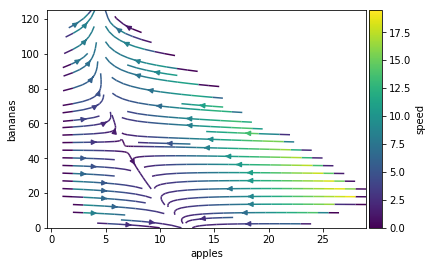

In [10]:
fig, ax = pm.plot_predictions_of_model_in_2D()
xlabel, ylabel = pm.X.columns.get_level_values('product_name')
ax.set(xlabel=xlabel, ylabel=ylabel)